## Resources:
Kernels:  
https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction Basic EDA and model for the train/test data  
https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features Advanced feature engineering, excellent code  
https://www.kaggle.com/poohtls/fork-of-fork-lightgbm-with-simple-features/ More advanced feature engineering  
https://www.kaggle.com/gemartin/load-data-reduce-memory-usage  reducing memory usage  

Discussions:  
https://www.kaggle.com/c/home-credit-default-risk/discussion/58332 Advice on this competition by Kaggle's GM  
https://www.kaggle.com/c/home-credit-default-risk/discussion/59308  KFold vs StratifiedKFold  
   
Research:  
http://www.chioka.in/class-imbalance-problem/  Class imbalance problem  
https://www.youtube.com/watch?v=OAl6eAyP-yo ROC Curve and AUC explained  
https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it Interpretation of AUC  
https://dnc1994.com/2016/05/rank-10-percent-in-first-kaggle-competition-en/ General advice on Kaggle, basic implementation of a stacking model
http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/ Boosting explained  
https://www.analyticsvidhya.com/blog/2015/11/quick-introduction-boosting-algorithms-machine-learning/ Boosting explained 2  
https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/ LightGBM vs XGBoost  
https://machinelearningmastery.com/best-tune-multithreading-support-xgboost-python/  XGBoost performance tuning  
https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_catboostclassifier-docpage/ CatBoost documentation  
https://github.com/catboost/catboost/issues/105 CatBoost killing kernel bug


'''
https://www.kaggle.com/c/home-credit-default-risk/discussion/58332
Silogram:
Actually, I run the CV just once. 
The purpose of the CV is to tune the lgb parameters, test features, and obtain the optimal number of iterations.
For submissions, I train 5 times on the full training set, changing the lgb seeds each time.
Then I take the mean of the predictions across each row.
Actually since the metric is auc, I take the rank mean, though it doesn't make a big difference in this case.
'''

'''
If you're using xgboost, switch to LightGBM, which is much faster.
(That's not to say that you shouldn't eventually use XGB to build a model,
but it makes more sense to start with LGB and then move on to XGB when you can no longer improve your LGB model.)'''

'''
Start with a relatively high learning rate (e.g., 0.2 or 0.1) and tune the other parameters with this high rate.
Then lower the learning rate and fine-tune the parameters.'''

## Log  

*1/07/2018*
> Working on top of https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features, using a stratified 5fold with LightGBM  
AUC CV: 0.791  
AUC LB: **0.794**  

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

In [3]:
# script to reduce memory usage -> https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtypes
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: #checing if the values fall within these ranges and reallocating them to optimise space
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else: df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # 1KB = 1024 bytes
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

#### Bureau files

In [4]:
bureau = pd.read_csv("C:\\Users\\heret\\Downloads\\bureau.csv")
bureau_balance = pd.read_csv("C:\\Users\\heret\\Downloads\\bureau_balance.csv")

print("bureau: ", bureau.shape)
print("bureau_balance: ", bureau_balance.shape)

#aggregations on months_balance
bureau_balance_agg = bureau_balance.drop(columns=["STATUS"]).groupby("SK_ID_BUREAU").agg(["mean", "max", "min", "sum","count"])
bureau_balance_agg.columns = ["months_balance"+"_" + colname for colname in bureau_balance_agg.columns.levels[1]]

#OHE and agg status
bureau_balance = pd.get_dummies(bureau_balance, dummy_na=True)
bureau_balance = bureau_balance.drop(columns=["MONTHS_BALANCE"]).groupby("SK_ID_BUREAU").agg(['sum', 'mean'])
bureau_balance.columns = [col[0]+"_"+col[1] for col in bureau_balance.columns.tolist()]

#merging the 2 sets
bureau_balance_agg = pd.concat((bureau_balance_agg, bureau_balance),sort=False,axis=1)

bureau:  (1716428, 17)
bureau_balance:  (27299925, 3)


In [5]:
bureau = bureau.join(bureau_balance_agg, how="left", on="SK_ID_BUREAU").drop(columns=["SK_ID_BUREAU"])

In [6]:
new_cols = [col for col in pd.get_dummies(bureau).columns if col not in bureau.columns]

num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    "months_balance_mean": ["mean"],
    "months_balance_max": ["max"],
    "months_balance_min": ["min"],
    "months_balance_sum": ["sum"],
    "months_balance_count": ["count"],
    "STATUS_0_sum": ["sum"],
    "STATUS_0_mean": ["mean"],
    "STATUS_1_sum": ["sum"],
    "STATUS_1_mean": ["mean"],
    "STATUS_2_sum": ["sum"],
    "STATUS_2_mean": ["mean"],
    "STATUS_3_sum": ["sum"],
    "STATUS_3_mean": ["mean"],
    "STATUS_4_sum": ["sum"],
    "STATUS_4_mean": ["mean"], 
    "STATUS_5_sum": ["sum"],
    "STATUS_5_mean": ["mean"],
    "STATUS_C_sum": ["sum"],
    "STATUS_C_mean": ["mean"],
    "STATUS_X_sum": ["sum"],
    "STATUS_X_mean": ["mean"]
}

bureau = pd.get_dummies(bureau, dummy_na=True)

cat_aggregations = {}
for new_col in new_cols: cat_aggregations[new_col] = ["mean"]

bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = [col[0]+"_"+col[1] for col in bureau_agg.columns.tolist()] #flatenning levels

# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau["CREDIT_ACTIVE_Active"] == 1]
active_agg = active.groupby("SK_ID_CURR").agg(num_aggregations)
active_agg.columns = pd.Index(["ACTIVE_" + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how="left", on="SK_ID_CURR")

# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau["CREDIT_ACTIVE_Closed"] == 1]
closed_agg = closed.groupby("SK_ID_CURR").agg(num_aggregations)
closed_agg.columns = pd.Index(["CLOSED_" + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how="left", on="SK_ID_CURR")

del closed, bureau, active, active_agg, closed_agg

#### previous_application file

In [7]:
previous_application = pd.read_csv("C:\\Users\\heret\\Downloads\\previous_application.csv")
print("previous_application: ", previous_application.shape)

previous_application["DAYS_FIRST_DRAWING"].replace(365243, np.nan, inplace= True)
previous_application["DAYS_FIRST_DUE"].replace(365243, np.nan, inplace= True)
previous_application["DAYS_LAST_DUE_1ST_VERSION"].replace(365243, np.nan, inplace= True)
previous_application["DAYS_LAST_DUE"].replace(365243, np.nan, inplace= True)
previous_application["DAYS_TERMINATION"].replace(365243, np.nan, inplace= True)

previous_application["APP_CREDIT_PERC"] = previous_application["AMT_APPLICATION"] / previous_application["AMT_CREDIT"]


new_cols = [col for col in pd.get_dummies(previous_application).columns if col not in previous_application.columns]
num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
}

previous_application = pd.get_dummies(previous_application)

cat_aggregations = {}
for new_col in new_cols: cat_aggregations[new_col] = ["mean"]
    
previous_agg = previous_application.groupby("SK_ID_CURR").agg({**num_aggregations, **cat_aggregations})
previous_agg.columns = [col[0]+"_"+col[1] for col in previous_agg.columns.tolist()] #flatenning levels

# Previous Applications: Approved Applications - only numerical features
approved = previous_application[previous_application["NAME_CONTRACT_STATUS_Approved"] == 1]
approved_agg = approved.groupby("SK_ID_CURR").agg(num_aggregations)
approved_agg.columns = pd.Index(["APPROVED_" + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
previous_agg = previous_agg.join(approved_agg, how="left", on="SK_ID_CURR")

# Previous Applications: Refused Applications - only numerical features
refused = previous_application[previous_application["NAME_CONTRACT_STATUS_Refused"] == 1]
refused_agg = refused.groupby("SK_ID_CURR").agg(num_aggregations)
refused_agg.columns = pd.Index(["REFUSED_" + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
previous_agg = previous_agg.join(refused_agg, how="left", on="SK_ID_CURR")
del refused, refused_agg, approved, approved_agg, previous_application

previous_application:  (1670214, 37)


#### POS_CASH_balance file

In [8]:
pos_cash_balance = pd.read_csv("C:\\Users\\heret\\Downloads\\POS_CASH_balance.csv")
print("pos_cash_balance: ", pos_cash_balance.shape)

pos_cash_balance.drop(columns=["SK_ID_PREV"], inplace=True)

new_cols = [col for col in pd.get_dummies(pos_cash_balance).columns if col not in pos_cash_balance.columns]
pos_cash_balance = pd.get_dummies(pos_cash_balance, dummy_na=True)

aggregations = {
    "MONTHS_BALANCE": ["max", "mean", "size"],
    "SK_DPD": ["max", "mean"],
    "SK_DPD_DEF": ["max", "mean"]
}
for cat in new_cols:
    aggregations[cat] = ["mean"]

pos_cash_balance_agg = pos_cash_balance.groupby("SK_ID_CURR").agg(aggregations)
pos_cash_balance_agg.columns = [col[0]+"_"+col[1] for col in pos_cash_balance_agg.columns.tolist()] #flatenning levels

# Count pos cash accounts
pos_cash_balance_agg["POS_COUNT"] = pos_cash_balance.groupby("SK_ID_CURR").size()

del pos_cash_balance

pos_cash_balance:  (10001358, 8)


#### instalments_payments file

In [9]:
installments_payments = pd.read_csv("C:\\Users\\heret\\Downloads\\installments_payments.csv")
print("installments_payments: ", installments_payments.shape)

installments_payments.drop(columns=["SK_ID_PREV"], inplace=True)

new_cols = [col for col in pd.get_dummies(installments_payments).columns if col not in installments_payments.columns]

installments_payments = pd.get_dummies(installments_payments, dummy_na=True)

# Percentage and difference paid in each installment (amount paid and installment value)
installments_payments["PAYMENT_PERC"] = installments_payments["AMT_PAYMENT"] / installments_payments["AMT_INSTALMENT"]
installments_payments["PAYMENT_DIFF"] = installments_payments["AMT_INSTALMENT"] - installments_payments["AMT_PAYMENT"]
# Days past due and days before due (no negative values)
installments_payments["DPD"] = installments_payments["DAYS_ENTRY_PAYMENT"] - installments_payments["DAYS_INSTALMENT"]
installments_payments["DBD"] = installments_payments["DAYS_INSTALMENT"] - installments_payments["DAYS_ENTRY_PAYMENT"]
installments_payments["DPD"] = installments_payments["DPD"].apply(lambda x: max(x,0))
installments_payments["DBD"] = installments_payments["DBD"].apply(lambda x: max(x,0))

aggregations = {
    "NUM_INSTALMENT_VERSION": ["nunique"],
    "DPD": ["max", "mean", "sum"],
    "DBD": ["max", "mean", "sum"],
    "PAYMENT_PERC": [ "mean",  "var"],
    "PAYMENT_DIFF": [ "mean", "var"],
    "AMT_INSTALMENT": ["max", "mean", "sum"],
    "AMT_PAYMENT": ["min", "max", "mean", "sum"],
    "DAYS_ENTRY_PAYMENT": ["max", "mean", "sum"]
}

for new_col in new_cols: aggregations[new_col] = ["mean"]

ins_agg = installments_payments.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = [col[0]+"_"+col[1] for col in ins_agg.columns.tolist()] #flatenning levels

ins_agg['INSTAL_COUNT'] = installments_payments.groupby('SK_ID_CURR').size()

del installments_payments

installments_payments:  (13605401, 8)


#### credit_card_balance file

In [10]:
credit_card_balance = pd.read_csv("C:\\Users\\heret\\Downloads\\credit_card_balance.csv")
print("credit_card_balance: ", credit_card_balance.shape)

credit_card_balance.drop(columns=["SK_ID_PREV"], inplace=True)

credit_card_balance = pd.get_dummies(credit_card_balance, dummy_na=True)

credit_card_balance_agg = credit_card_balance.groupby("SK_ID_CURR").agg(["mean", "max", "var", "sum"])
credit_card_balance_agg.columns = [col[0]+"_"+col[1] for col in credit_card_balance_agg.columns.tolist()] #flatenning levels

credit_card_balance_agg['CC_COUNT'] = credit_card_balance.groupby('SK_ID_CURR').size()

del credit_card_balance

credit_card_balance:  (3840312, 23)


#### train & test files

In [11]:
train = pd.read_csv("C:\\Users\\heret\\Downloads\\application_train.csv")
test = pd.read_csv("C:\\Users\\heret\\Downloads\\application_test.csv")

In [12]:
train = train[train['CODE_GENDER'] != 'XNA'] #removes 4 ids with XNA value for gender

all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
ntrain = train.shape[0]
ntest = test.shape[0]

In [13]:
all_data["DAYS_EMPLOYED"].replace(365243, np.nan, inplace= True)

#new variables
docs = [_f for _f in all_data.columns if "FLAG_DOC" in _f]
live = [_f for _f in all_data.columns if ("FLAG_" in _f) & ("FLAG_DOC" not in _f) & ("_FLAG_" not in _f)]
    
inc_by_org = all_data[["AMT_INCOME_TOTAL", "ORGANIZATION_TYPE"]].groupby("ORGANIZATION_TYPE").median()["AMT_INCOME_TOTAL"]

all_data['INCOME_CREDIT_PERC'] = all_data['AMT_INCOME_TOTAL'] / all_data['AMT_CREDIT']
all_data['INCOME_PER_PERSON'] = all_data['AMT_INCOME_TOTAL'] / all_data['CNT_FAM_MEMBERS']
all_data['PAYMENT_RATE'] = all_data['AMT_ANNUITY'] / all_data['AMT_CREDIT']

all_data["NEW_CREDIT_TO_ANNUITY_RATIO"] = all_data["AMT_CREDIT"] / all_data["AMT_ANNUITY"]
all_data["NEW_CREDIT_TO_GOODS_RATIO"] = all_data["AMT_CREDIT"] / all_data["AMT_GOODS_PRICE"]
all_data["NEW_DOC_IND_KURT"] = all_data[docs].kurtosis(axis=1)
all_data["NEW_LIVE_IND_SUM"] = all_data[live].sum(axis=1)
all_data["NEW_INC_PER_CHLD"] = all_data["AMT_INCOME_TOTAL"] / (1 + all_data["CNT_CHILDREN"])
all_data["NEW_INC_BY_ORG"] = all_data["ORGANIZATION_TYPE"].map(inc_by_org)
all_data["NEW_EMPLOY_TO_BIRTH_RATIO"] = all_data["DAYS_EMPLOYED"] / all_data["DAYS_BIRTH"]
all_data["NEW_ANNUITY_TO_INCOME_RATIO"] = all_data["AMT_ANNUITY"] / (1 + all_data["AMT_INCOME_TOTAL"])
all_data["NEW_SOURCES_PROD"] = all_data["EXT_SOURCE_1"] * all_data["EXT_SOURCE_2"] * all_data["EXT_SOURCE_3"]
all_data["NEW_EXT_SOURCES_MEAN"] = all_data[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mean(axis=1)
all_data["NEW_SCORES_STD"] = all_data[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].std(axis=1)
all_data["NEW_SCORES_STD"] = all_data["NEW_SCORES_STD"].fillna(all_data["NEW_SCORES_STD"].mean())
all_data["NEW_CAR_TO_BIRTH_RATIO"] = all_data["OWN_CAR_AGE"] / all_data["DAYS_BIRTH"]
all_data["NEW_CAR_TO_EMPLOYED_RATIO"] = all_data["OWN_CAR_AGE"] / all_data["DAYS_EMPLOYED"]
all_data["NEW_PHONE_TO_BIRTH_RATIO"] = all_data["DAYS_LAST_PHONE_CHANGE"] / all_data["DAYS_BIRTH"]
all_data["NEW_PHONE_TO_EMPLOYED_RATIO"] = all_data["DAYS_LAST_PHONE_CHANGE"] / all_data["DAYS_EMPLOYED"]
all_data["NEW_CREDIT_TO_INCOME_RATIO"] = all_data["AMT_CREDIT"] / all_data["AMT_INCOME_TOTAL"]
# features commented out create infinite values see all_data.columns[~np.isfinite(all_data).all()]

# categorical variables
print(all_data.select_dtypes("object").columns)

for bin_feature in ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]:
    all_data[bin_feature], uniques = pd.factorize(all_data[bin_feature]) #factorizing these binary features instead of OHE
    
all_data = pd.get_dummies(all_data)

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')


In [14]:
all_data = all_data.join(bureau_agg, how="left", on="SK_ID_CURR")
all_data = all_data.join(previous_agg, how="left", on="SK_ID_CURR", lsuffix="left", rsuffix="right")
all_data = all_data.join(credit_card_balance_agg, how="left", on="SK_ID_CURR", lsuffix="left", rsuffix="right")
all_data = all_data.join(pos_cash_balance_agg, how="left", on="SK_ID_CURR", lsuffix="left", rsuffix="right")
all_data = all_data.join(ins_agg, how="left", on="SK_ID_CURR", lsuffix="left", rsuffix="right")

In [15]:
all_data = reduce_mem_usage(all_data)

Memory usage of dataframe is 1860.80 MB
Memory usage after optimization is: 649.60 MB
Decreased by 65.1%


In [16]:
ids = test["SK_ID_CURR"]
train_y = train["TARGET"]#.values
train_X = all_data.drop(columns=["TARGET", "SK_ID_CURR"],axis=1)[:ntrain]
test_X = all_data.drop(columns=["TARGET", "SK_ID_CURR"],axis=1)[ntrain:]
train_X, test_X = train_X.align(test_X, join = 'inner', axis = 1)
#train_X, test_X = train_X.values, test_X.values

del test, train, bureau_agg, bureau_balance_agg, previous_agg, credit_card_balance_agg, ins_agg, pos_cash_balance_agg, all_data

print("______")
print("train_X: ", train_X.shape, "   train_y: ", train_y.shape, "   test_X: ", test_X.shape)

______
train_X:  (307507, 799)    train_y:  (307507,)    test_X:  (48744, 799)


### Modeling

In [37]:
xgbclass = XGBClassifier(
    n_jobs=-1,
    n_estimators=3000,
    colsample_bytree=0.7,
    subsample=0.7,
    learning_rate=0.075,
    max_depth=7,
    silent=-1,
    verbose=-1,
    eval_metric="auc"
)

catboost = CatBoostClassifier(
    thread_count=4,
    iterations=3000,
    nan_mode="Min", #does not support NaN classes, either "Min"/"Max" or previous imputation to prevent dead kernel
    eval_metric='AUC',
    depth=7,
    learning_rate=0.02,
    #subsample=0.7,
    l2_leaf_reg=40,
    #bootstrap_type='Bernoulli',
    #scale_pos_weight=5,
    #metric_period=50,
    od_type='Iter',
    od_wait=150,  #number of rounds after the most recent best iteration to wait before stopping, relies on od_type="Iter"
    allow_writing_files=False,
)


lgbm = LGBMClassifier(
    nthread=4,
    n_estimators=3000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    silent=-1,
    verbose=-1, 
)

def stacked(X,y,T,clf,n_folds=5):
    
    folds = StratifiedKFold(n_splits=n_folds, shuffle=True)
    valid_preds = np.zeros(X.shape[0])
    test_preds = np.zeros(T.shape[0])
    feature_importance_df = pd.DataFrame()

    
    for fold_no, (train_idx, valid_idx) in enumerate(folds.split(X,y)):
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_valid = X.iloc[valid_idx]
        y_valid = y.iloc[valid_idx]
  
        if clf.__class__.__name__ == "XGBClassifier":
            clf.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_valid, y_valid)], verbose=30, eval_metric= 'auc', early_stopping_rounds=30)
            valid_preds[valid_idx] = clf.predict_proba(X_valid, ntree_limit=clf.best_iteration)[:, 1]
            test_preds += clf.predict_proba(T, ntree_limit=clf.best_iteration)[:, 1] / folds.n_splits
        elif clf.__class__.__name__ == "LGBMClassifier":
            clf.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_valid, y_valid)], verbose=100, eval_metric= 'auc', early_stopping_rounds=300)
            valid_preds[valid_idx] = clf.predict_proba(X_valid, num_iteration=clf.best_iteration_)[:, 1]
            test_preds += clf.predict_proba(T, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
        elif clf.__class__.__name__ == "CatBoostClassifier":
            clf.fit(X=train_X, y=train_y, verbose=30, eval_set=[(X_valid, y_valid)], use_best_model=True)
            valid_preds[valid_idx] = clf.predict_proba(X_valid)[:, 1]
            test_preds += clf.predict_proba(T)[:, 1] / folds.n_splits
            
        fold_importance_df = pd.DataFrame({'importance': clf.feature_importances_, 'feature': X.columns})
        fold_importance_df["fold"] = fold_no + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print('Full AUC score %.5f' % roc_auc_score(y, valid_preds))
    
    cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:75].index
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
    plt.figure(figsize=(10,16))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title(str(clf.__class__.__name__ + " Features (avg over folds)"))
    plt.tight_layout()
    
    
    return (valid_preds, test_preds)

Training until validation scores don't improve for 300 rounds.
[100]	training's auc: 0.776066	valid_1's auc: 0.762438
[200]	training's auc: 0.798342	valid_1's auc: 0.77715
[300]	training's auc: 0.811674	valid_1's auc: 0.783683
[400]	training's auc: 0.821838	valid_1's auc: 0.786984
[500]	training's auc: 0.830496	valid_1's auc: 0.789195
[600]	training's auc: 0.838185	valid_1's auc: 0.790789
[700]	training's auc: 0.844816	valid_1's auc: 0.791646
[800]	training's auc: 0.851036	valid_1's auc: 0.792381
[900]	training's auc: 0.856838	valid_1's auc: 0.792797
[1000]	training's auc: 0.862271	valid_1's auc: 0.793286
[1100]	training's auc: 0.867576	valid_1's auc: 0.79366
[1200]	training's auc: 0.872266	valid_1's auc: 0.793774
[1300]	training's auc: 0.877069	valid_1's auc: 0.793675
[1400]	training's auc: 0.881758	valid_1's auc: 0.793679
[1500]	training's auc: 0.886044	valid_1's auc: 0.793716
Early stopping, best iteration is:
[1220]	training's auc: 0.873362	valid_1's auc: 0.793843
Training until va

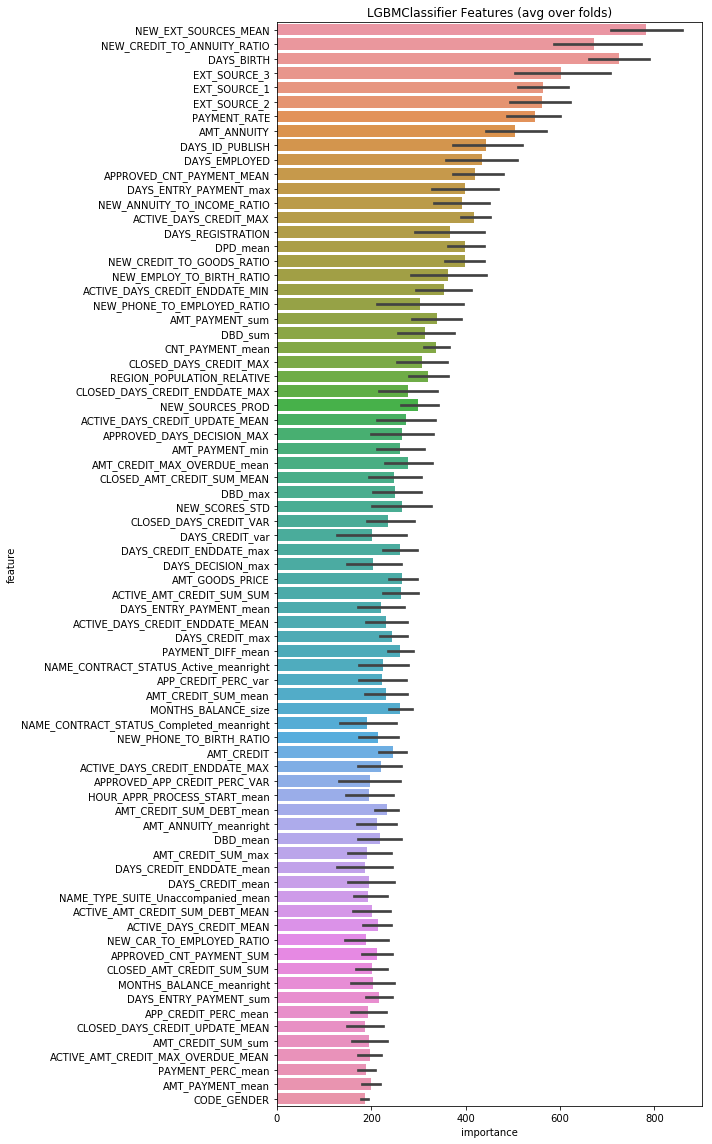

In [35]:
%%time
valid_preds_lgbm, test_preds_lgbm = stacked(train_X,train_y,test_X,lgbm)

In [36]:
my_submission = pd.DataFrame({"SK_ID_CURR": ids, "TARGET": test_preds_lgbm})
my_submission.to_csv("lgbmv3.csv", index=False)
my_submission.head(10)

,SK_ID_CURR,TARGET
0,100001,0.033657
1,100005,0.124002
2,100013,0.024783
3,100028,0.043388
4,100038,0.153467
5,100042,0.045393
6,100057,0.005844
7,100065,0.024604
8,100066,0.009553
9,100067,0.080552
